## Part 1

Real estate dataset from: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [39]:
import pymc as pm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_csv('realtor-data.csv.csv')
sampled_data = data.sample(n=10000, random_state=42) #dataset is too big to run pymc so i reduced it to 10,000 observations

sampled_data = sampled_data.dropna()


features = ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size']
X = sampled_data[features].values
y = sampled_data['price'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

with pm.Model() as MLR:
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = pm.math.dot(X, betas)

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(1000, return_inferencedata=True)


             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  1411.41   9.96  1391.78  1429.13       0.21     0.15    2247.0   
betas[1]  2658.33  10.05  2638.92  2675.89       0.19     0.13    2910.0   
betas[2]   -43.65  10.09   -62.66   -25.48       0.20     0.15    2606.0   
betas[3]  -317.40   9.67  -334.73  -299.29       0.20     0.14    2451.0   
betas[4]  2421.09  10.24  2401.62  2440.20       0.19     0.13    3018.0   
sigma     8671.01   0.51  8670.03  8671.91       0.01     0.01    2610.0   

          ess_tail  r_hat  
betas[0]    1527.0    1.0  
betas[1]    1666.0    1.0  
betas[2]    1516.0    1.0  
betas[3]    1718.0    1.0  
betas[4]    1663.0    1.0  
sigma       1615.0    1.0  


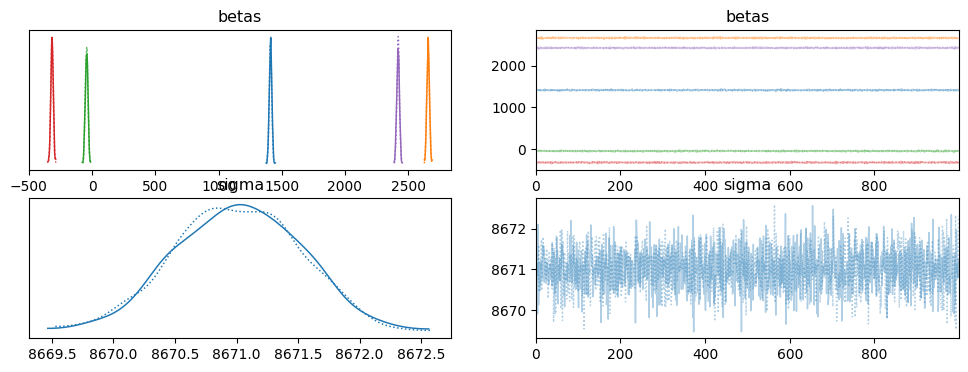

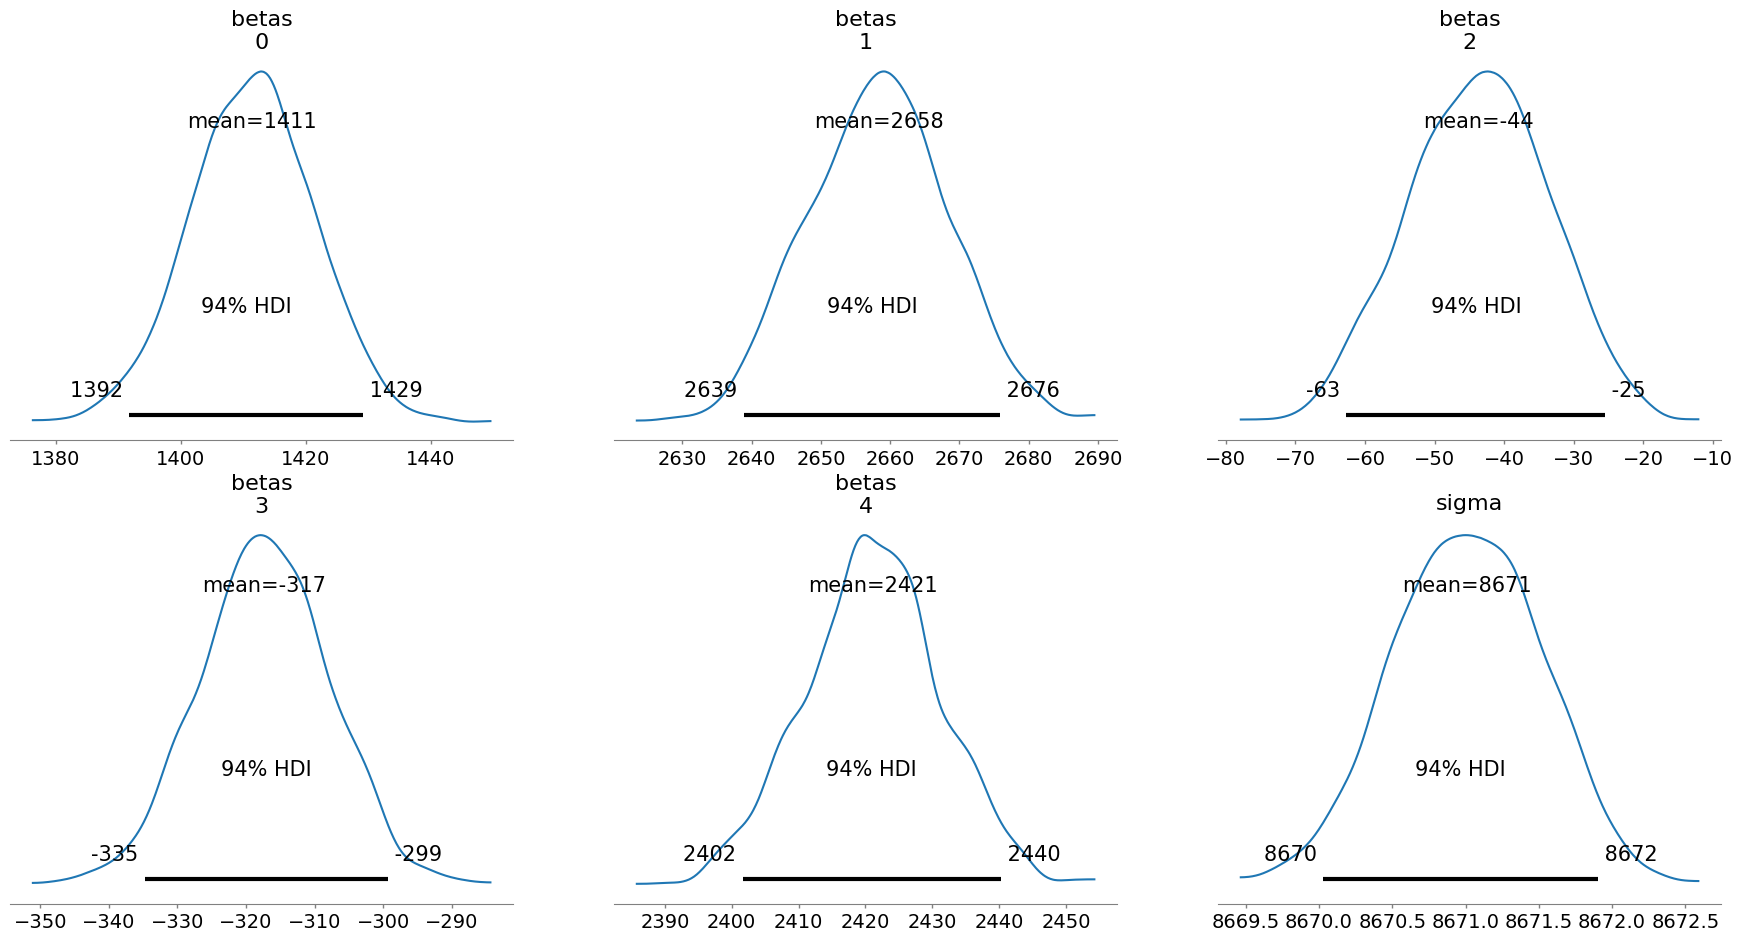

In [40]:
import arviz as az

with MLR:
    az.plot_trace(trace)
    az.plot_posterior(trace)
    summary = az.summary(trace).round(2)

print(summary)

## Part 2



\begin{align*}
p(\mathbf{y} | \boldsymbol \beta, \boldsymbol \Sigma, \mathbf{X}) = {} & (2\pi )^{-n/2}\det({\boldsymbol {\Sigma }})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\beta})^\top{\boldsymbol {\Sigma }}^{-1}(\mathbf{y} - \mathbf{X\beta})\right)\\
\propto {} & \exp\left(\mathbf{\beta}^\top\mathbf{X}^\top\boldsymbol\Sigma^{-1}\mathbf{y} - \frac{1}{2}\mathbf{\beta}^\top \mathbf{X}^\top \boldsymbol\Sigma^{-1} \mathbf{X\beta} \right)\\
p(\boldsymbol \beta) \propto 1 \Longrightarrow {} & p(\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}) = \mathcal{MVN}\left(E[\boldsymbol \beta] = (\mathbf{X}^\top \boldsymbol\Sigma^{-1} \mathbf{X})^{-1}\mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y}, \text{Var}[\boldsymbol \beta] = \left[\mathbf{X}^{\top} \boldsymbol\Sigma^{-1} \mathbf{X} \right]^{-1} \right)\\
\end{align*}


### 1. Rewriting $ p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}) $ in terms of $ \sigma^2 $

When $\boldsymbol \Sigma = \sigma^2 \mathbf{I}$, we have:

\begin{align*}
p(\boldsymbol \beta |\sigma^2, \mathbf{X},\mathbf{y}) = \mathcal{MVN}\left(E[\boldsymbol \beta | \sigma^2, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top}\frac{1}{\sigma^2} \mathbf{X} + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}\left( \mathbf{X}^\top \frac{1}{\sigma^2}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right), \text{Var}[\boldsymbol \beta | \sigma^2, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top}\frac{1}{\sigma^2} \mathbf{X} + \boldsymbol \Sigma_\beta^{-1} \right]^{-1} \right)
\end{align*}

### 2. Expected Value $ E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] $

The expected value is given by:

\begin{align*}
E[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top} \boldsymbol\Sigma^{-1} \mathbf{X} + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}\left( \mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right)
\end{align*}

### 3. Hyperparameters for Specific Expected Value

To achieve $ E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y} $, we can set:

- $ \boldsymbol \Sigma_\beta $ to be very large (effectively an uninformative prior).
- $ \boldsymbol \beta_0 = \mathbf{0} $ and $ \boldsymbol \Sigma_\beta^{-1} = \mathbf{0} $.

### 4. Hyperparameters for Specific Expected Value of $ \mathbf{\hat y} $

To achieve $ E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y} $, the hyperparameters must be the same as in part 3.

### 5. Variance $ \text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] $

The variance of the posterior distribution of $\boldsymbol \beta$ is:

\begin{align*}
\text{Var}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top} \boldsymbol \Sigma^{-1} \mathbf{X} + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}
\end{align*}


## Part 3

In [41]:
from sklearn.preprocessing import StandardScaler

data = sampled_data

features = ['bed', 'bath', 'acre_lot', 'house_size', 'price']
X = data[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

p = X_scaled.shape[1]

with pm.Model() as model:

    sd_dist = pm.Exponential.dist(1.0 / X_scaled.std(axis=0), size=p)


    chol, _, _ = pm.LKJCholeskyCov('chol_cov', eta=1, n=p, sd_dist=sd_dist)


    mu = pm.Normal('mu', mu=np.zeros(p), sigma=np.ones(p), shape=p)


    y_obs = pm.MvNormal('y_obs', mu=mu, chol=chol, observed=X_scaled)


    trace = pm.sample(1000, return_inferencedata=True, tune=2000, target_accept=0.99)

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


In [42]:
with MLR:
    summary = az.summary(trace).round(2)

print(summary)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu[0]               -0.00  0.02   -0.04     0.04        0.0      0.0   
mu[1]               -0.00  0.02   -0.04     0.03        0.0      0.0   
mu[2]               -0.00  0.02   -0.03     0.03        0.0      0.0   
mu[3]               -0.00  0.02   -0.04     0.04        0.0      0.0   
mu[4]               -0.00  0.02   -0.04     0.04        0.0      0.0   
chol_cov[0]          1.00  0.01    0.98     1.02        0.0      0.0   
chol_cov[1]          0.62  0.02    0.59     0.65        0.0      0.0   
chol_cov[2]          0.79  0.01    0.77     0.81        0.0      0.0   
chol_cov[3]         -0.00  0.02   -0.04     0.03        0.0      0.0   
chol_cov[4]         -0.00  0.02   -0.04     0.04        0.0      0.0   
chol_cov[5]          1.00  0.01    0.98     1.03        0.0      0.0   
chol_cov[6]          0.56  0.02    0.53     0.60        0.0      0.0   
chol_cov[7]          0.51  0.02    0.48     0.54        0.0     